In [193]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from pandarallel import pandarallel, core

from exotools.spectra import read_stick_output
from exotools.exotools import states_df

from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler

In [152]:

D_stick = read_stick_output("../XSEC/Stick/X2Pi_to_12Delta/OH_XD_300K.out",predicted_shifts=False)
D = D_stick[[i for i in D_stick.columns if "Lambda" not in i and "Sigma" not in i and "E_" not in i]]
D["Branch"] = D["J_upper"]-D["J_lower"]
D["Branch"] = np.select(
    [
        D["Branch"]>0,
        D["Branch"]==0,
        D["Branch"]<0
    ],
    [
        "R",
        "Q",
        "P"
    ])

/tmp/ipykernel_4043/2181150334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D["Branch"] = D["J_upper"]-D["J_lower"]
/tmp/ipykernel_4043/2181150334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D["Branch"] = np.select(


In [ ]:
#D[(D["v_lower"]==0) & (D["v_upper"]==0) & (D["J_lower"]==2.5) & (D.duplicated(["Omega_upper","Omega_lower","Branch"]))].sort_values("Branch")
# D[D.J_upper ==D.J_upper.min()].sort_values(["Branch","Omega_lower"])

v0 = D[(D["v_lower"]==0)&(D["v_upper"]==0)]
# v0[v0["J_lower"]==3.5].sort_values("Branch")
v0_grouped = v0.groupby(["J_lower", "Branch"], as_index = False).agg(nu = ("nu","mean"))
for branch in v0_grouped.Branch.unique():
    curr = v0_grouped[v0_grouped["Branch"]==branch].sort_values("nu")
    nu = curr["nu"].to_numpy()
    d_nu = np.diff(nu)
    plt.plot(nu[1:],d_nu)


In [ ]:
grouped = D[D["v_lower"]==0].assign(Omega_band = lambda x: x["Omega_lower"].astype(str)+x["Omega_upper"].astype(str)).groupby(["v_upper","v_lower","Omega_band","Branch"],as_index=False).agg(nu = ("nu","mean"))
for branch in grouped.Branch.unique():
    curr = grouped[grouped["Branch"]==branch].sort_values("nu")
    nu = curr["nu"].to_numpy()
    d_nu = np.diff(nu)
    plt.plot(nu[1:],d_nu)

In [42]:
D_states = states_df("../STF/X2Pi_to_12Delta.states")
D_states[D_states["Manifold"]=="12Delta"].sort_values("E")

,NN,E,gns,J,tau,e/f,Manifold,v,Lambda,Sigma,Omega
706,707,51455.915494,8,1.5,1.0,f,12Delta,0,2,-0.5,1.5
1773,1774,51455.915494,12,2.5,1.0,e,12Delta,0,2,0.5,2.5
1240,1241,51455.915494,8,1.5,-1.0,e,12Delta,0,-2,0.5,-1.5
2460,2461,51455.915494,12,2.5,-1.0,f,12Delta,0,-2,-0.5,-2.5
2462,2463,51460.389407,12,2.5,-1.0,f,12Delta,0,-2,0.5,-1.5
...,...,...,...,...,...,...,...,...,...,...,...
56561,56562,132198.143140,172,42.5,1.0,e,12Delta,145,2,-0.5,1.5
54568,54569,132202.014450,164,40.5,-1.0,f,12Delta,146,-2,-0.5,-2.5
53902,53903,132202.014450,164,40.5,1.0,e,12Delta,146,2,0.5,2.5
53236,53237,132202.014450,160,39.5,-1.0,e,12Delta,146,-2,0.5,-1.5


In [145]:
D[D["I"]>1e-30]["v_lower"].unique()

array([0, 1, 2, 3, 4, 5, 6])

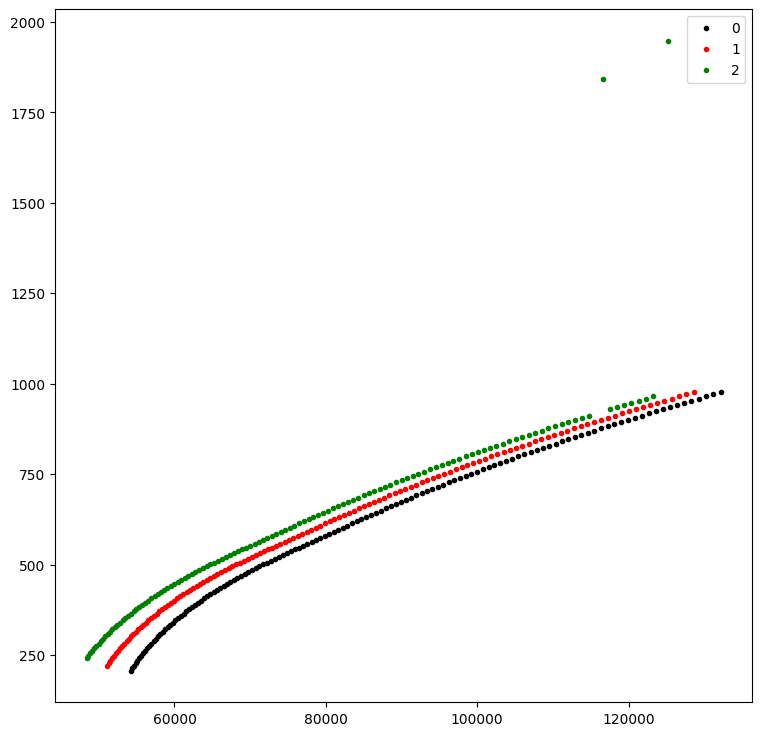

In [150]:
plt.figure(figsize = (9,9))

colors = {
    "0":"k",
    "1":"r",
    "2":"g",
    "3":"b",
    "4":"m",
    "5":"y",
    "6":"k",
    "7":"r",
    "8":"g"
}

for v in sorted(D.v_lower.unique())[0:3]:
    clr = colors[f"{v}"]

    curr = D[(D["J_upper"]==1.5)&(D["J_lower"]==1.5)&(D["Omega_lower"]==-1.5)&(D["tau_upper"]=="+")&(D["v_lower"]==v)]
    nu   = curr.sort_values("nu")["nu"].to_numpy()
    dnu, nu = np.diff(nu), nu[1:]
    plt.plot(nu, dnu,clr+".", label = f"{v}")
    popt = np.polyfit(nu, dnu**2, 1)
    dnu_f = np.poly1d(popt)(np.linspace(30000,130000,1000))
    # plt.plot(np.linspace(30000,130000,1000), np.sqrt(dnu_f), clr+"-")
plt.legend(loc = "best")

In [188]:
D = D[
    (D["I"]>=1e-40) &
    (D["J_lower"]==1.5) & 
    (D["Omega_lower"]==-1.5)
    ]

grp = D.groupby(["v_lower","v_upper"], as_index = False).agg(nu = ("nu","min"))

for v in grp.v_lower.unique():
    curr = grp[grp.v_lower == v].sort_values("v_upper")
    nu = curr.nu.to_numpy()
    dnu, nu = np.diff(nu), nu[1:]
    # popt = np.polyfit(nu, dnu**2, 1)
    # f_nu = np.poly1d(popt)(nu)
    
    model = HuberRegressor(epsilon=1)
    model.fit(nu, dnu)

    model.predict(nu)

    plt.plot(nu,dnu**2)
    plt.plot(nu,f_nu)

ValueError: Expected 2D array, got 1D array instead:
array=[ 51474.5772  51504.8552  51545.7024  51597.8388  51660.416   51731.9308
  51812.5171  51902.4044  52000.8285  52107.5783  52222.8106  52346.2132
  52477.659   52617.1844  52764.5672  52919.7171  53082.5295  53252.8481
  53430.6246  53615.7576  53808.1987  54007.892   54214.7551  54428.7356
  54649.7682  54877.7761  55112.7334  55354.5624  55603.2276  55858.6855
  56120.8755  56389.7636  56665.303   56947.4437  57236.1638  57531.4163
  57833.1735  58141.4088  58456.0774  58777.1556  59104.605   59438.3843
  59778.4654  60124.7954  60477.3418  60836.0697  61200.9412  61571.9344
  61949.0108  62332.1387  62721.2852  63116.3981  63517.4472  63924.3819
  64337.1713  64755.7819  65180.1768  65610.3219  66046.1684  66487.666
  66934.7678  67387.4184  67845.5814  68309.2077  68778.261   69252.6935
  69732.4595  70217.5208  70707.8393  71203.39    71704.1431  72210.0738
  72721.1566  73237.373   73758.7194  74285.2026  74816.8415  75353.6579
  75895.6769  76442.9306  76995.4587  77553.3126  78116.5477  78685.2251
  79259.4049  79839.147   80424.5088  81015.542   81612.2924  82214.7987
  82823.0975  83437.2223  84057.2047  84683.0714  85314.844   85952.5397
  86596.1724  87245.7548  87901.2973  88562.8091  89230.2968  89903.766
  90583.221   91268.6652  91960.1013  92657.5307  93360.9541  94070.3718
  94785.7837  95507.1891  96234.5867  96967.9754  97707.3539  98452.7206
  99204.074   99961.4119 100724.732  101494.031  102269.307  103050.556
 103837.776  104630.963  105430.114  106235.226  107046.296  107863.321
 108686.297  109515.222  110350.091  111190.903  112037.654  112890.341
 113748.962  114613.514  115483.994  116360.4    117242.731  118130.984
 119025.157  119925.249  120831.256  121743.177  122661.009  123584.749
 124514.395  125449.944  126391.393  127338.742  128291.986  129251.122
 130216.148  131187.06   132163.853 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

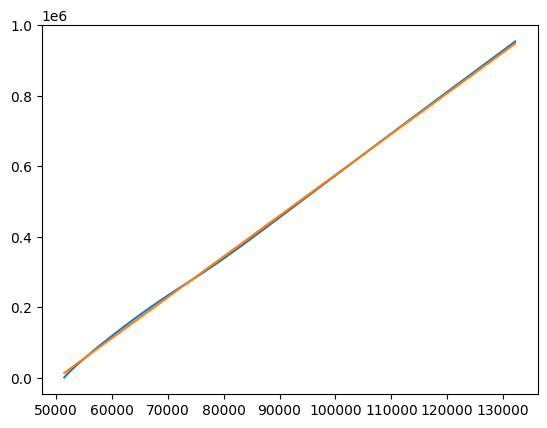

In [232]:
curr = grp[grp.v_lower == 0].sort_values("v_upper")
nu = curr.nu.to_numpy()
y, x = np.diff(nu)**2, nu[1:]
x = x.reshape(-1,1)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

model = HuberRegressor()
model.fit(x_scaled,y)

y_pred = model.predict(x_scaled)

plt.plot(x,y)
plt.plot(x,y_pred)


In [237]:
StandardScaler().transform(x_scaled)

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [208]:

D = read_stick_output("../XSEC/Stick/X2Pi_to_12Delta/OH_XD_300K.out",predicted_shifts=False)
D["Branch"] = D["J_upper"]-D["J_lower"]
D["Branch"] = np.select(
    [
        D["Branch"]>0,
        D["Branch"]==0,
        D["Branch"]<0
    ],
    [
        "R",
        "Q",
        "P"
    ])

def smooth_xsec_fds(df, J_lower, Omega_lower):
    df = df[
        (df["J_lower"]==J_lower)&
        (df["Omega_lower"]==Omega_lower)
        ]
    
    grouped = df.groupby(["v_lower","v_upper"], as_index = False).agg(nu = ("nu","mean"))

D
    
    

,nu,I,J_upper,J_lower,tau_upper,e/f_upper,Manifold_upper,v_upper,Omega_upper,tau_lower,e/f_lower,Manifold_lower,v_lower,Omega_lower,Branch
10698,51455.9155,4.718020e-39,1.5,1.5,+,f,12Delta,0,1.5,-,e,X2Pi,0,-1.5,Q
10699,51474.5772,1.572926e-38,1.5,1.5,+,f,12Delta,1,1.5,-,e,X2Pi,0,-1.5,Q
10700,51504.8552,5.464959e-38,1.5,1.5,+,f,12Delta,2,1.5,-,e,X2Pi,0,-1.5,Q
10701,51545.7024,1.590212e-37,1.5,1.5,+,f,12Delta,3,1.5,-,e,X2Pi,0,-1.5,Q
10702,51597.8388,4.392679e-37,1.5,1.5,+,f,12Delta,4,1.5,-,e,X2Pi,0,-1.5,Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15439,96835.8213,7.186484e-40,2.5,1.5,+,e,12Delta,125,2.5,-,e,X2Pi,3,-1.5,R
15441,97652.8460,4.690167e-40,2.5,1.5,+,e,12Delta,126,2.5,-,e,X2Pi,3,-1.5,R
15443,98475.8222,2.974625e-40,2.5,1.5,+,e,12Delta,127,2.5,-,e,X2Pi,3,-1.5,R
15445,99304.7467,1.823583e-40,2.5,1.5,+,e,12Delta,128,2.5,-,e,X2Pi,3,-1.5,R
